In [1]:
%cd ../..
%load_ext autoreload
%autoreload 2

/home/amir/rqc_internship/frame_stack


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import join as jn
import os
import yaml
import torch
from torchinfo import summary
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, Dataset


In [3]:
from video_pipeline.video_module import *

import matplotlib.pyplot as plt
from IPython.display import clear_output
import time 

In [4]:
with open('params.yaml') as conf_file:
    config = yaml.safe_load(conf_file)
with open('pathes.yaml') as conf_file:
    path_config = yaml.safe_load(conf_file)

pressure_path = path_config['p_video_path']
signal_path = path_config['s_video_path']


#### opening dataset file and visualizing video

In [5]:

input_path = path_config['s_video_path']
output_path = path_config['p_video_path']

tr = config['video_train']
frames_number, frames_interval = tr["frames_number"], tr["frames_interval"]

def get_elemenst_from_dataset(slice, key_id=10):
    '''
    usage example:
    i = 100
    pressure, signal = get_elemenst_from_dataset(slice(i, i+20))
    pressure.shape, signal.shape
    plt.imshow(pressure[0])
    plt.show()
    '''
    pressure_path, signal_path = jn(output_path, 'test'), jn(input_path, 'test')
    name = "test.hdf5"
    # i = 50

    with h5py.File(jn(signal_path, name)) as signal_file, \
            h5py.File(jn(pressure_path, name)) as pres_file:
            key = list(signal_file.keys())[key_id]
                # for key in tqdm(signal_file.keys(), dynamic_ncols=True, position=1, leave=False):

            signal = (signal_file[key][slice].astype(np.float32))
            pressure = (pres_file[key][slice].astype(np.float32))
    return pressure, signal

In [6]:
# loading data
pressure, signal = get_elemenst_from_dataset(slice(300), key_id=100)
# plt.imshow(pressure[0])
# plt.show()

### ML model loading

In [7]:
import torch_sensor_lib as tsl
sim = tsl.FiberSimulator(config)

In [8]:

if not torch.cuda.is_available():
    print('CUDA is NOT available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# %%
tr = config['video_train']

CUDA is NOT available.  Training on CPU ...


In [9]:

signal_shape, pressure_shape = (1, 4, 64), (64, 64)
print('input chain shape: ', signal_shape, '\noutput chain shape: ',
      pressure_shape)

model_name = tr['model_name']
from video_pipeline import models_src

model_class = eval(f"models_src.{model_name}")

args = []
if model_name.startswith("Param"):
    layers = tr['layers']
    args.append(layers)
args.append(frames_number)
args.append(frames_interval)
model = model_class(pressure_shape[-2:], signal_shape[-2:], *args)
model = model.to(device)

input chain shape:  (1, 4, 64) 
output chain shape:  (64, 64)


In [10]:
checkpoint = torch.load("data/365_id_model.pt",
                     map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

model.eval();

До сюда шапка, которую нужно запускать каждый раз.

### пытаюсь понять, что не так с новой симуляцией.

In [11]:

input_path = path_config['s_video_path']
output_path = path_config['p_video_path']
ds_type = ["test", "train"][1]
pressure_path, signal_path = jn(output_path, ds_type), jn(input_path, ds_type)
files = os.listdir(pressure_path)
assert(len(files) == 1)
name = files[0]

signal_file = h5py.File(jn(signal_path, name)) 
pres_file = h5py.File(jn(pressure_path, name))
keys = list(signal_file.keys())
print(len(keys))
# signal = (signal_file[key][slice].astype(np.float32))
# pressure = (pres_file[key][slice].astype(np.float32))
        


11136


In [12]:
key = "731_43"
strange_pressure = pres_file[key][:]
strange_signal = signal_file[key][:]


101


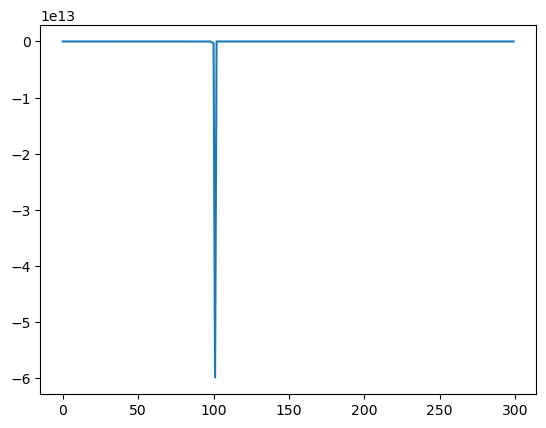

In [13]:
mean_signal = strange_signal.mean(axis=(1, 2))
strange_frame = np.where(mean_signal < -5e13)[0][0]
print(strange_frame)
plt.plot(mean_signal)

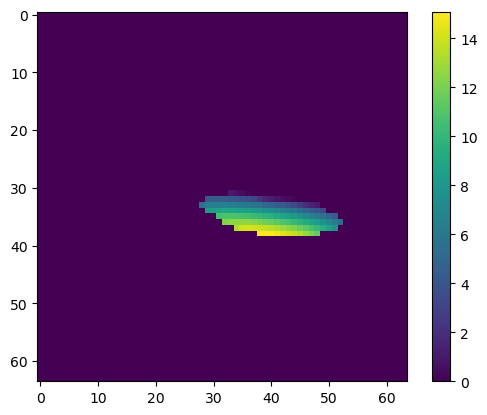

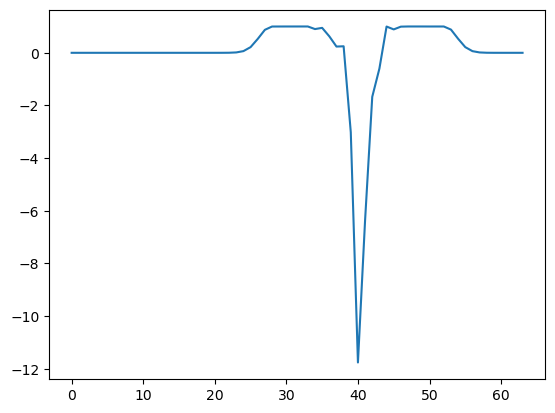

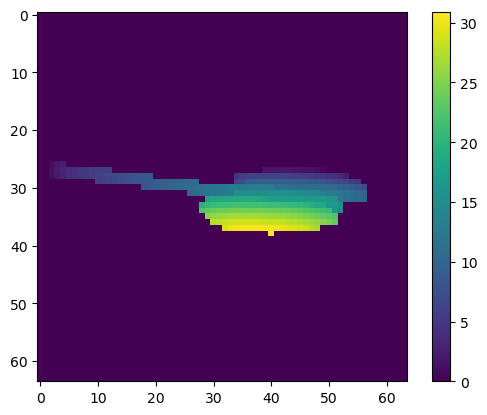

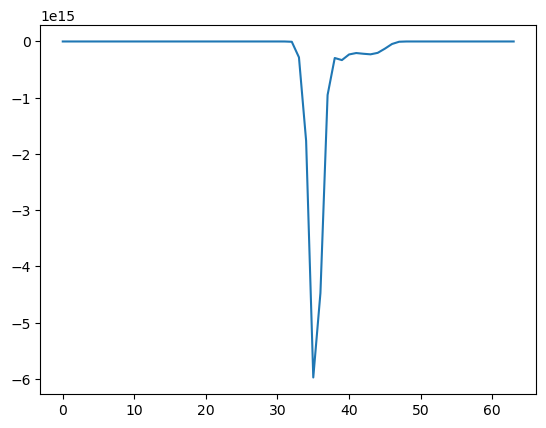

In [14]:
strange_pressure_frame = strange_pressure[strange_frame-9].astype(np.float32)
strange_signal_frame = strange_signal[strange_frame-9]
plt.imshow(strange_pressure_frame)
plt.colorbar()
plt.show()
plt.plot(strange_signal_frame[0])
plt.show()

strange_pressure_frame = strange_pressure[strange_frame].astype(np.float32)
strange_signal_frame = strange_signal[strange_frame]
plt.imshow(strange_pressure_frame)
plt.colorbar()
plt.show()
plt.plot(strange_signal_frame[0])

### запускаем debug режим симуляции на этом кадре

In [15]:
with open('params.yaml') as conf_file:
    d_config = yaml.safe_load(conf_file)
d_config["sim"]['test_mod'] = True
d_config["env"]["sen_geometry"]['n_angles'] = 1
import torch_bimodal_sim_lib as tbsl
d_simb = tbsl.FiberSimulator(d_config)

Rot tensors


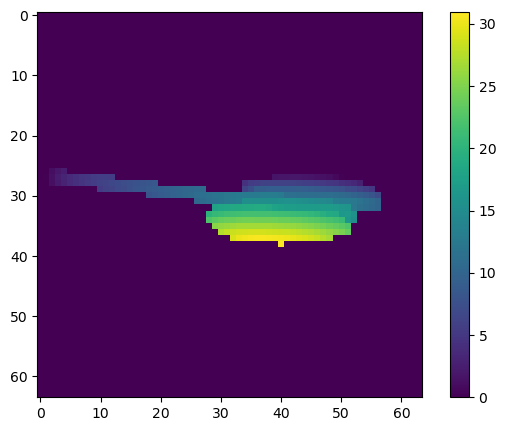

After blur


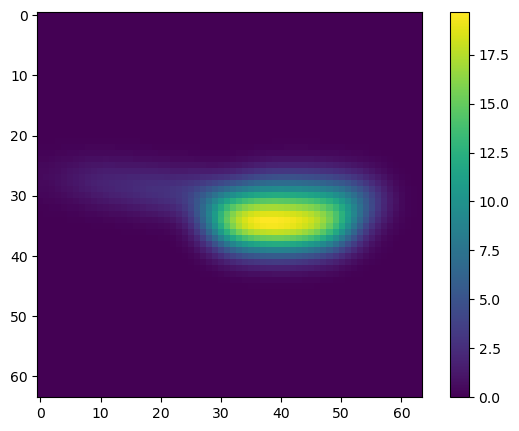

Curvature


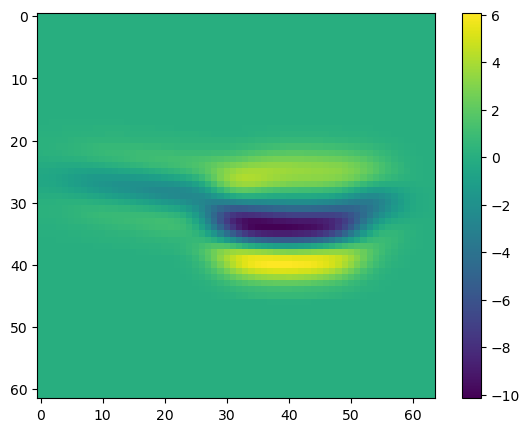

/home/amir/rqc_internship/frame_stack/torch_bimodal_sim_lib/sim.py:59: UserWarning: Integrated value is very big. (54.17984390258789 >> 1). Consider using smaller intgrated length step.
  warnings.warn(f"Integrated value is very big. ({max_integrate} >> 1)."+ \


Loss sums


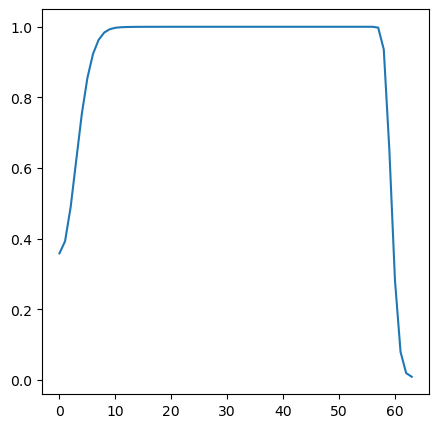

In [16]:
d_simb.fiber_real_sim(strange_pressure_frame);

Так вот получается, если заменить просто линейную функцию на экспоненту. -inf не получается, но получается ноль

Попробуем посмотреть на результат симуляции других объектов и на результат старой симуляции на этом объекте. Может тут и нормально выдавать ноль.

In [17]:
import torch_sensor_lib as tsl
d_sim = tsl.FiberSimulator(d_config)

Rot tensors


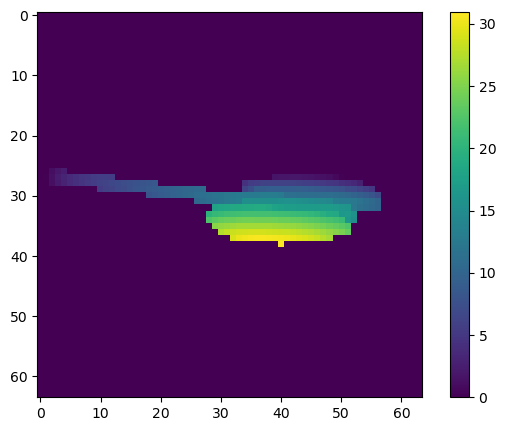

After blur


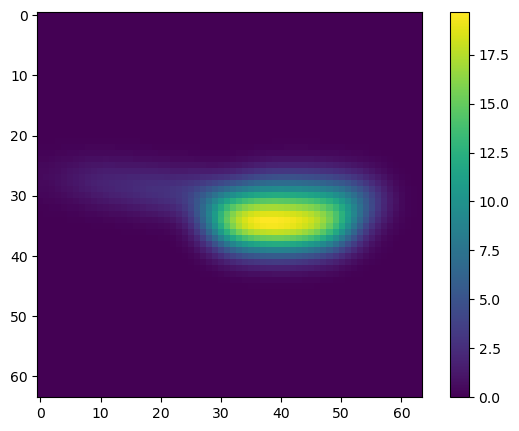

Loss in fiber


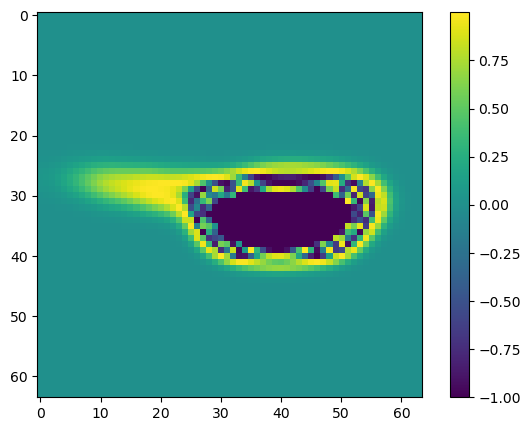

Loss sums


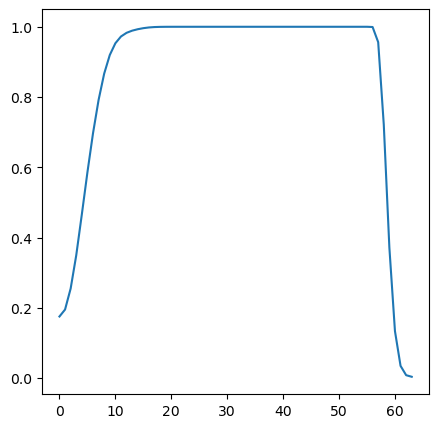

Signal


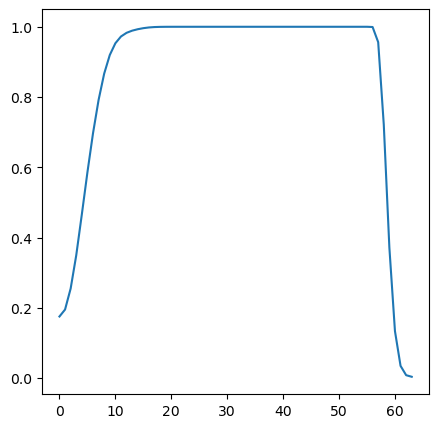

In [18]:
d_sim.fiber_real_sim(strange_pressure_frame);

Ну да. Прошлая симуляция выдавала тут тоже 1, так что ничего не должно сломаться, если использовать тут фикс экспонентой.

Посмотрим, что нейросетка предсказывает для этого кадра

In [19]:
import torch_sensor_lib as tsl
sim = tsl.FiberSimulator(config)

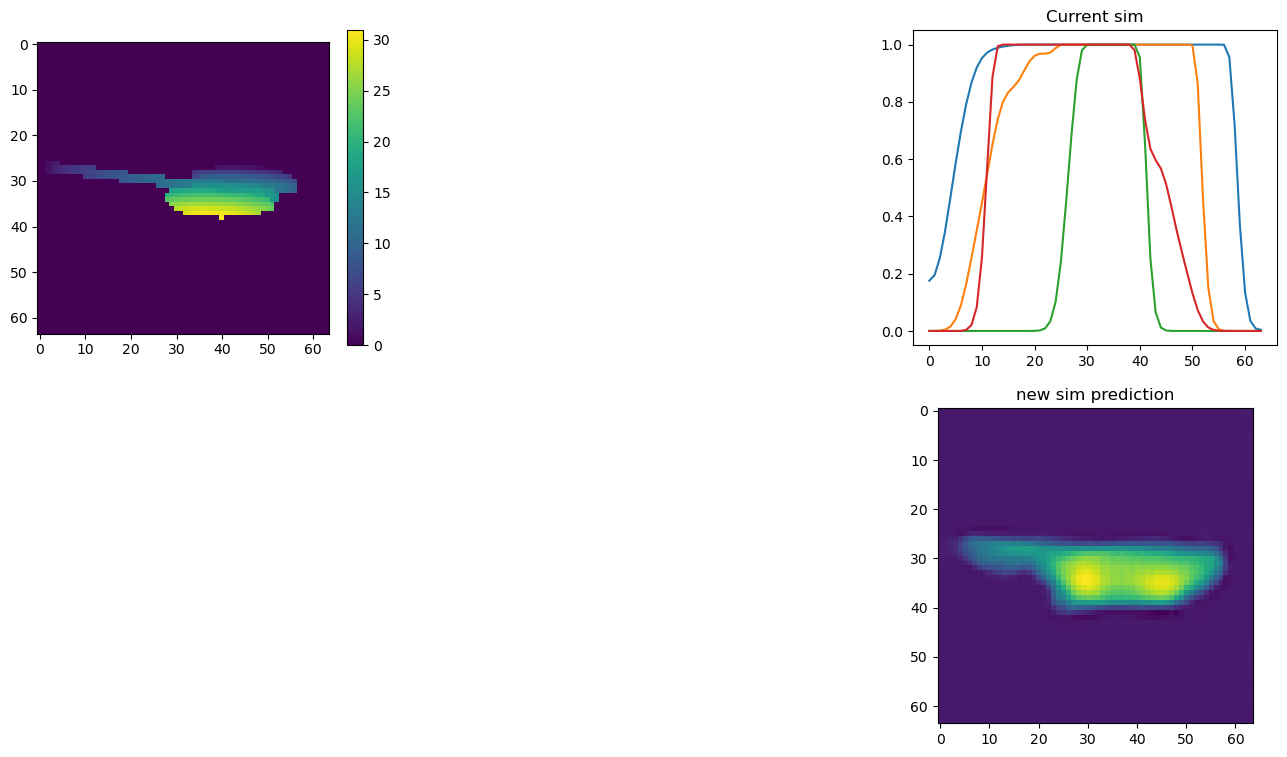

In [20]:

plt.figure(figsize=(16, 9))
plt.subplot(2, 3, 1)
plt.imshow(strange_pressure_frame)
plt.colorbar()

plt.subplot(2, 3, 3)
new_signal = sim.fiber_real_sim(strange_pressure_frame)
plt.plot(new_signal[0].T)
plt.title("Current sim")


plt.subplot(2, 3, 6)
map = predict(model, new_signal, device)
plt.imshow(map[0])
plt.title("new sim prediction")

plt.show()
time.sleep(0.5)

Все совсем хорошо. Раз нейросетка проглатывает такой сигнал, так и будем работать.